<a href="https://colab.research.google.com/github/graxel/payouts/blob/master/Payouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Data

I started by downloading the three files to my personal computer. I looked at their sizes and saw that they would fit in memory without issue, so I decided to use Pandas for this project.

I import all the packages I will later use in this notebook, and read in the three files, taking care to parse the date column in payouts.csv:


In [ ]:
import datetime as dt
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy as sp
import scipy.stats as stats
from sklearn import preprocessing
import statsmodels.api as sm

try:
    countries = pd.read_csv('countries.csv')
    industries = pd.read_csv('industries.csv')
    payouts = pd.read_csv('payouts.csv', parse_dates=['date'])
    print('Read from this notebook')
except:
    countries = pd.read_csv('drive/My Drive/Stripe/countries.csv')
    industries = pd.read_csv('drive/My Drive/Stripe/industries.csv')
    payouts = pd.read_csv('drive/My Drive/Stripe/payouts.csv', parse_dates=['date'])
    print('Read from Google Drive')

Read from Google Drive


# Exploring the Data


Like the **Steps Forward** section under Question 1, this whole **Exploring the Data** section can be ignored. I included it in case a hiring manager might be interested to see how I think. 

Here I take a look at the tables on their own, without any JOINs, just to get a feel for the data.

## Countries

In [ ]:
countries.info()
countries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112309 entries, 0 to 112308
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   merchant_id  112309 non-null  object
 1   country      112309 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


,merchant_id,country
0,id_ace715763434d4fd4eda58c9e9d692c6,FR
1,id_717b4a0f74912f18146c0708b330a3d9,US
2,id_671fd54bccd294b502fea89c0cc5a690,US
3,id_d8ed94b4e446b868e38efa8efa34b702,FR
4,id_1a054e523cbf203b16b38fc3e5b19b25,US


Define a short function to show the number of unique values in each column:

In [ ]:
def num_unique(df):
    for col in df:
        print(col,len(df[col].unique()))

In [ ]:
num_unique(countries)

merchant_id 112309
country 25


Note: All the merchant ids are unique in countries.csv.

In [ ]:
countries['country'].unique()

array(['FR', 'US', 'CA', 'JP', 'BE', 'ES', 'HK', 'GB', 'DE', 'NO', 'BR',
       'CH', 'SG', 'AU', 'NZ', 'DK', 'IT', 'AT', 'IE', 'FI', 'MX', 'SE',
       'LU', 'PT', 'NL'], dtype=object)

Let's see how many merchants are in each country:

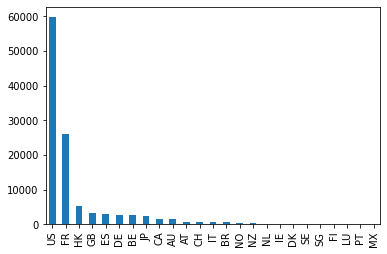

In [ ]:
countries['country'].value_counts().plot(kind='bar')

In [ ]:
countries[countries['country'].isin(['US', 'FR'])]['country'].value_counts().sum() / countries['country'].value_counts().sum()

0.765210268099618

Wow, looks like over three quarters of all merchants are located in the US and France.

## Industries

In [ ]:
industries.info()
industries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112309 entries, 0 to 112308
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   merchant_id  112309 non-null  object
 1   industry     112308 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


,merchant_id,industry
0,id_ace715763434d4fd4eda58c9e9d692c6,Travel & Hospitality
1,id_717b4a0f74912f18146c0708b330a3d9,Food & Beverage
2,id_671fd54bccd294b502fea89c0cc5a690,Professional Services (non-medical)
3,id_d8ed94b4e446b868e38efa8efa34b702,Travel & Hospitality
4,id_1a054e523cbf203b16b38fc3e5b19b25,Professional Services (non-medical)


Quick check on that null value in the industry column:

In [ ]:
industries[industries['industry'].isnull()]

,merchant_id,industry
70951,id_b877e047c48a77aa883cd3bbba95ce58,NaN


In [ ]:
num_unique(industries)

merchant_id 112309
industry 18


In [ ]:
industries['industry'].value_counts(dropna=False)

Other Software & Content                             26037
Travel & Hospitality                                 18370
Other Services                                       15902
Professional Services (non-medical)                  14527
Food & Beverage                                      12221
Non-profit                                            9269
Tickets: concerts,sports,movies,conventions           8081
Content                                               4730
Education                                             1010
Retail Fashion                                         994
Other Retail                                           603
Healthcare                                             389
Direct Services: classes,memberships,appointments      171
Real Estate                                              1
Financial Services                                       1
hotels, restaurants & leisure                            1
internet software & services                            

Don't want to seem overzealous, but it might be worth revising some of these industry categories. For example:

* The single merchant in "hotels, restaurants & leisure" might be classed with "Travel & Hospitality" or "Food & Beverage"
* The single merchant in "internet software & services" might be classed with "Other Software & Content"


## Payouts

In [ ]:
payouts.info()
payouts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622642 entries, 0 to 1622641
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   date          1622642 non-null  datetime64[ns, UTC]
 1   platform_id   1622642 non-null  object             
 2   recipient_id  1622642 non-null  object             
 3   count         1622642 non-null  int64              
 4   amount        1622642 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 61.9+ MB


,date,platform_id,recipient_id,count,amount
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0


In [ ]:
num_unique(payouts)

date 365
platform_id 463
recipient_id 112030
count 49
amount 295241


Are any recipients on more than one platform?

In [ ]:
unique_plats_by_recip = payouts.groupby('recipient_id')['platform_id'].apply(lambda x: len(set(x)))
unique_plats_by_recip[unique_plats_by_recip > 1]

Series([], Name: platform_id, dtype: int64)

Nope.

The questions asked have a time component to them, let's see how the payout frequency is distributed over time. This is a plot of the number of payouts per day:

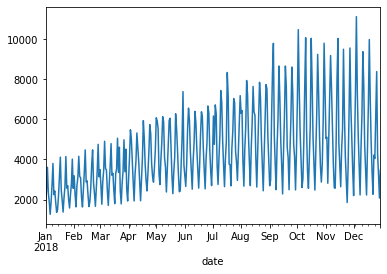

In [ ]:
payouts.groupby(pd.Grouper(key='date',freq='D',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(len).iloc[:-1].plot()

Grouping by day doesn't give a clear trend, however those weekly spikes might be something worth looking at later. Let's try grouping by one-week and four-week windows:

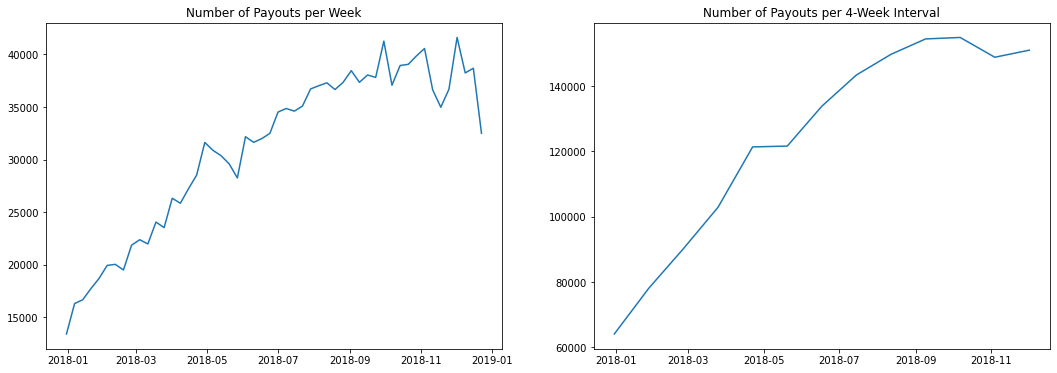

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ax[0].set_title('Number of Payouts per Week')
ax[1].set_title('Number of Payouts per 4-Week Interval')

num_payouts_per_time_1w = payouts.groupby(pd.Grouper(key='date',freq='W',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(len).iloc[:-1]

num_payouts_per_time_4w = payouts.groupby(pd.Grouper(key='date',freq='4W',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(len).iloc[:-1]

ax[0].plot(num_payouts_per_time_1w.index, num_payouts_per_time_1w)
ax[1].plot(num_payouts_per_time_4w.index, num_payouts_per_time_4w)

plt.show()

There's a pretty clear trend of the number of payouts per unit time doubling over the course of 2018.



It might be interesting to see how the *sum* of payouts per unit time changed over the course of the year:

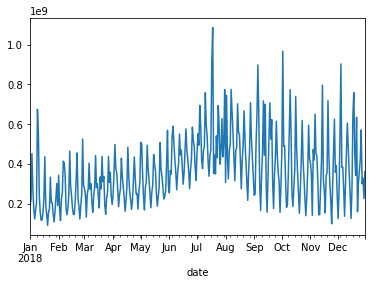

In [ ]:
payouts.groupby(pd.Grouper(key='date',freq='D',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(sum).iloc[:-1].plot()

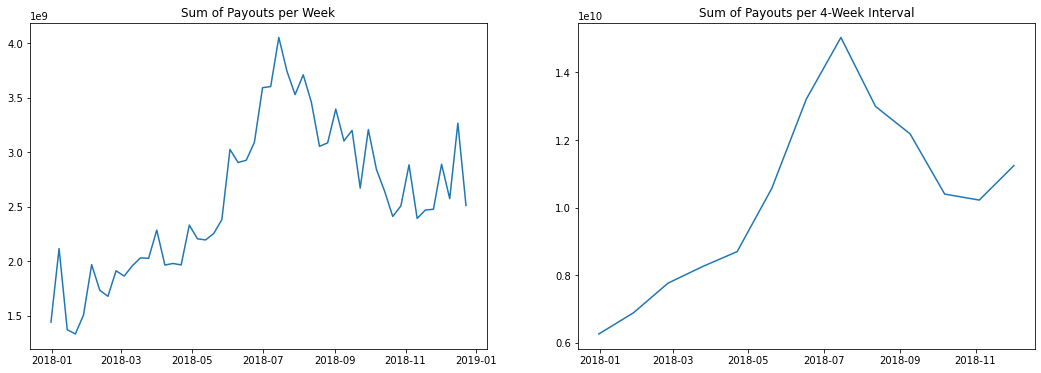

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ax[0].set_title('Sum of Payouts per Week')
ax[1].set_title('Sum of Payouts per 4-Week Interval')

sum_of_payouts_per_time_1w = payouts.groupby(pd.Grouper(key='date',freq='W',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(sum).iloc[:-1]

sum_of_payouts_per_time_4w = payouts.groupby(pd.Grouper(key='date',freq='4W',
    closed='left', label='left', convention='start'))\
    ['amount'].apply(sum).iloc[:-1]

ax[0].plot(sum_of_payouts_per_time_1w.index, sum_of_payouts_per_time_1w)
ax[1].plot(sum_of_payouts_per_time_4w.index, sum_of_payouts_per_time_4w)

plt.show()

It's looks like there might be some monthly artifacts in the plot above.

# Question 1 - Tomorrow's expected payout volume, by country

*Using the data provided, please provide an estimate for the amount of money we should expect to be paid out to each country tomorrow.*

I build a predictive model to return the expected payout total per country, for a given date.

## Setup

In [ ]:
payouts.head()

,date,platform_id,recipient_id,count,amount
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0


In [ ]:
# Joining the payouts and countries tables
df = payouts.merge(countries, how='left', left_on='recipient_id', right_on='merchant_id').drop(columns='recipient_id')
df.head()

,date,platform_id,count,amount,merchant_id,country
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,1,9786.0,id_23d90ec275370c686dedd7dc1c5e93b3,US
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,1,3750.0,id_72f05535ba5e6e5b141db6b5c1f1b13b,FR
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,1,2258.0,id_d70e8046fe5583e1154b2e077133e27c,GB
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,1,20369.0,id_1a336bd21b4bfd9810e0510e1a5f7ec2,US
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,1,34922.0,id_c577aeddec71607ec0be1f94bef025da,US


## Linear Regression
Build a simple linear model, extrapolate to today.

### Setup and EDA

In [ ]:
# grouping by country and date
daily_payout_totals_by_country = df.groupby(['country', pd.Grouper(key='date',freq='D',
    closed='left', label='left', convention='start')])\
    ['amount'].apply(sum)

# building an index with all combinations of date and country
all_countries = df['country'].dropna().unique()
all_dates = pd.date_range(freq='D', start=df['date'].min(), end=df['date'].max())
idx = pd.MultiIndex.from_product([all_countries, all_dates], names=['country', 'date'])

# reindexing and filling blanks with 0 to account for countries that 
# may not have had any payouts on a certain date
daily_payout_totals_by_country = daily_payout_totals_by_country.reindex(index=idx, fill_value=0)

# unstacking the data into a dataframe
daily_payout_totals_by_country = daily_payout_totals_by_country.unstack(level=0)

daily_payout_totals_by_country.head()

country,AT,AU,BE,BR,CA,CH,DE,DK,ES,FI,FR,GB,HK,IE,IT,JP,LU,MX,NL,NO,NZ,PT,SE,SG,US
date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,2487.0,1833517.0,183827.0,4976.0,7373215.0,0.0,5212.0,151371.0,64374.0,296200.0,1716103.0,57117.0,0.0,2681.0,21145.0,793022.0,0.0,0.0,20752.0,0.0,11597.0,0.0,614.0,0.0,184345229.0
2018-01-02 00:00:00+00:00,144687.0,918292.0,740681.0,44887.0,10551814.0,0.0,3490.0,25078.0,12681.0,0.0,824280.0,2000319.0,0.0,78374.0,32438.0,1509761.0,0.0,0.0,0.0,72149.0,3172.0,0.0,3460.0,0.0,201404716.0
2018-01-03 00:00:00+00:00,47083.0,4228035.0,190272.0,82956.0,15850354.0,0.0,47723.0,38911.0,49450.0,0.0,792592.0,587355.0,0.0,7092.0,62159.0,2899764.0,0.0,0.0,0.0,143380.0,0.0,0.0,28238.0,0.0,425615954.0
2018-01-04 00:00:00+00:00,27541.0,1751532.0,208143.0,56516.0,12493504.0,0.0,3360.0,85854.0,79711.0,4122.0,646035.0,259369.0,0.0,1140.0,23333.0,1829156.0,0.0,0.0,148591.0,35464.0,0.0,0.0,13145.0,3295.0,256007822.0
2018-01-05 00:00:00+00:00,21491.0,1122473.0,394261.0,49910.0,2433320.0,3097.0,432482.0,54836.0,13041.0,8458.0,2563230.0,281500.0,42629.0,2741539.0,28873.0,1175558.0,0.0,0.0,0.0,49843.0,11029.0,0.0,6203.0,559.0,163779300.0


Let's see what this data looks like.

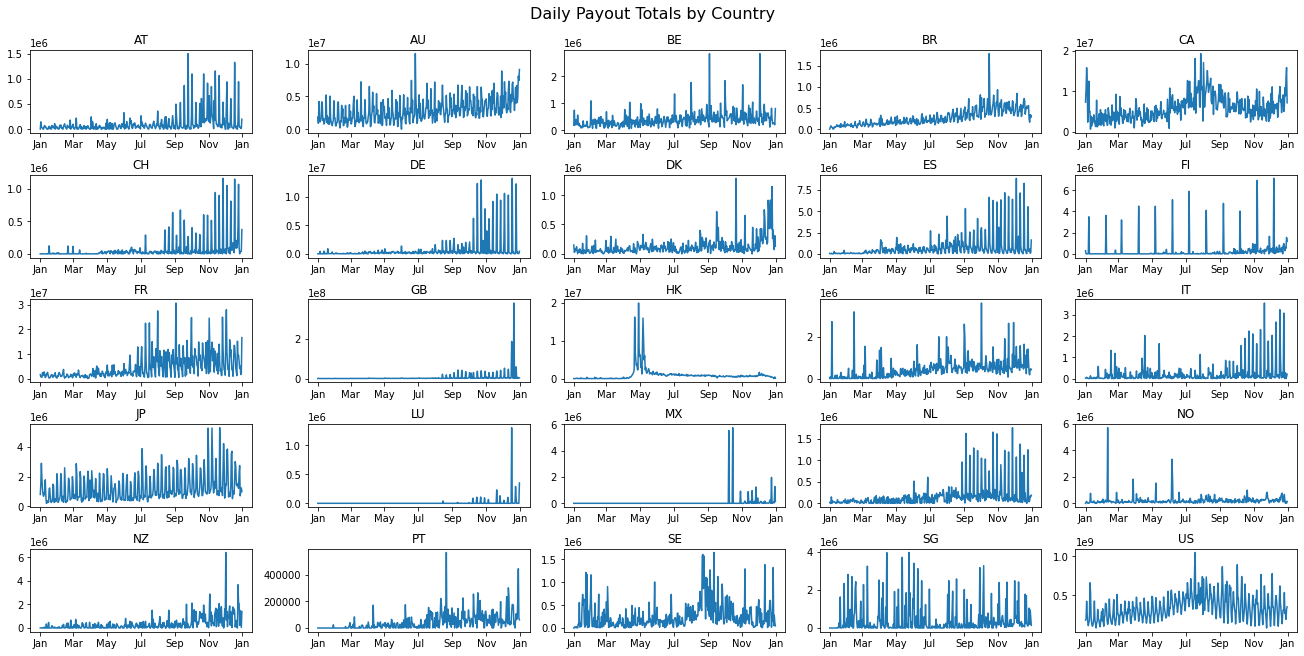

In [ ]:
# Make the date axis look nice:
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%b")


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Daily Payout Totals by Country', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    sum_of_payouts_per_time = daily_payout_totals_by_country[country_name]
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].plot(sum_of_payouts_per_time.index, sum_of_payouts_per_time)
    ax[r,c].xaxis.set_major_formatter(date_format)

plt.show()

To understand how the data is distributed, I slice each country's data into one month windows and normalize each slice before recombining them. Finally, I plot a histogram of the normalized data for each country.

In [ ]:
from sklearn import preprocessing

def slice_normalize_stack(sum_of_payouts_per_time):
    sum_of_payouts_per_time = sum_of_payouts_per_time[sum_of_payouts_per_time>0] #drop zeroes
    sum_of_payouts_per_time = pd.DataFrame({
        'amount':sum_of_payouts_per_time, 
        'month':sum_of_payouts_per_time.index.month, 
        'day':sum_of_payouts_per_time.index.day})

    sum_of_payouts_by_month = sum_of_payouts_per_time.pivot(
                            index='day', columns='month', values='amount')

    avg_std_dev = np.mean(np.std(sum_of_payouts_by_month)) # find overall scale factors
    avg_mean = np.mean(np.mean(sum_of_payouts_by_month)) # find overall scale factors

    scaler = preprocessing.StandardScaler() # standardize data
    standardized_sum_of_payouts_by_month = scaler.fit_transform(sum_of_payouts_by_month)
    standardized_sum_of_payouts_by_month = pd.DataFrame(
                        data=scaler.fit_transform(sum_of_payouts_by_month),
                        columns=sum_of_payouts_by_month.columns)

    standardized_payouts = pd.DataFrame(standardized_sum_of_payouts_by_month).stack()

    normalized_payouts = ((standardized_payouts*avg_std_dev)+avg_mean) 
    # scale it back to its original size. Means and standard deviations should about equal
    
    return normalized_payouts

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


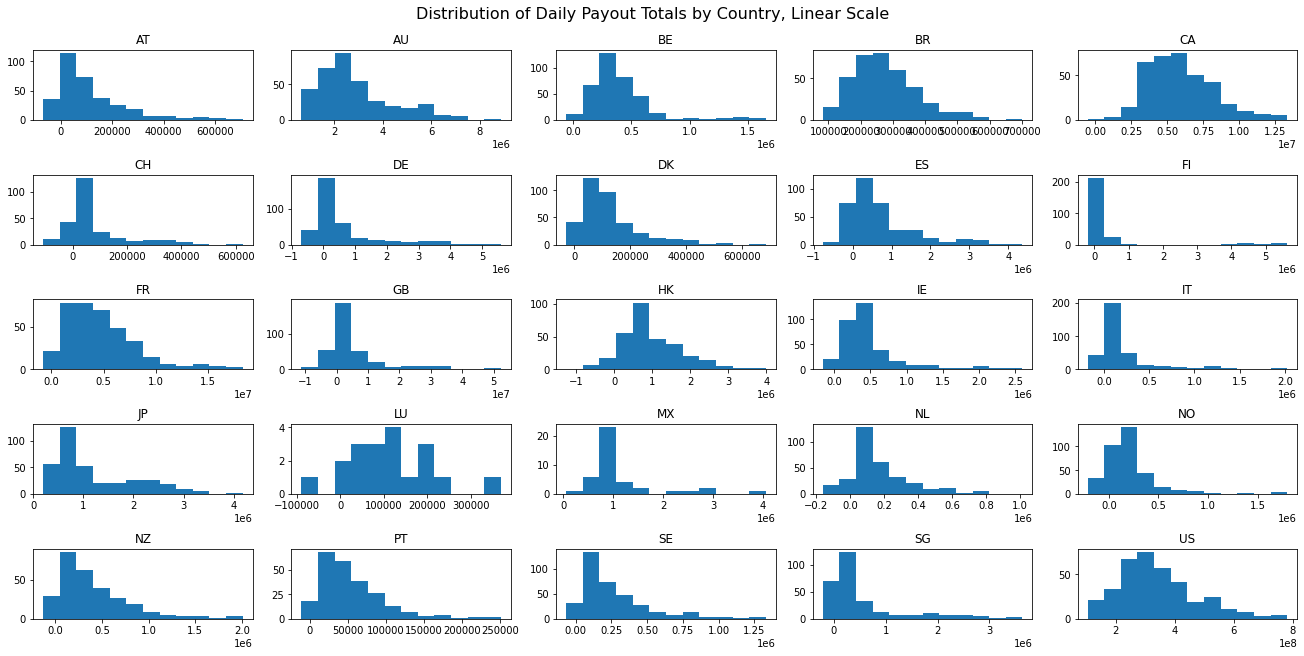

In [ ]:
normalized_payouts_by_country = daily_payout_totals_by_country.apply(slice_normalize_stack, axis=0)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Distribution of Daily Payout Totals by Country, Linear Scale', fontsize=16)

for n, country_name in enumerate(normalized_payouts_by_country.columns):
    normalized_payouts = normalized_payouts_by_country[country_name]
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].hist(normalized_payouts, bins=12)

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


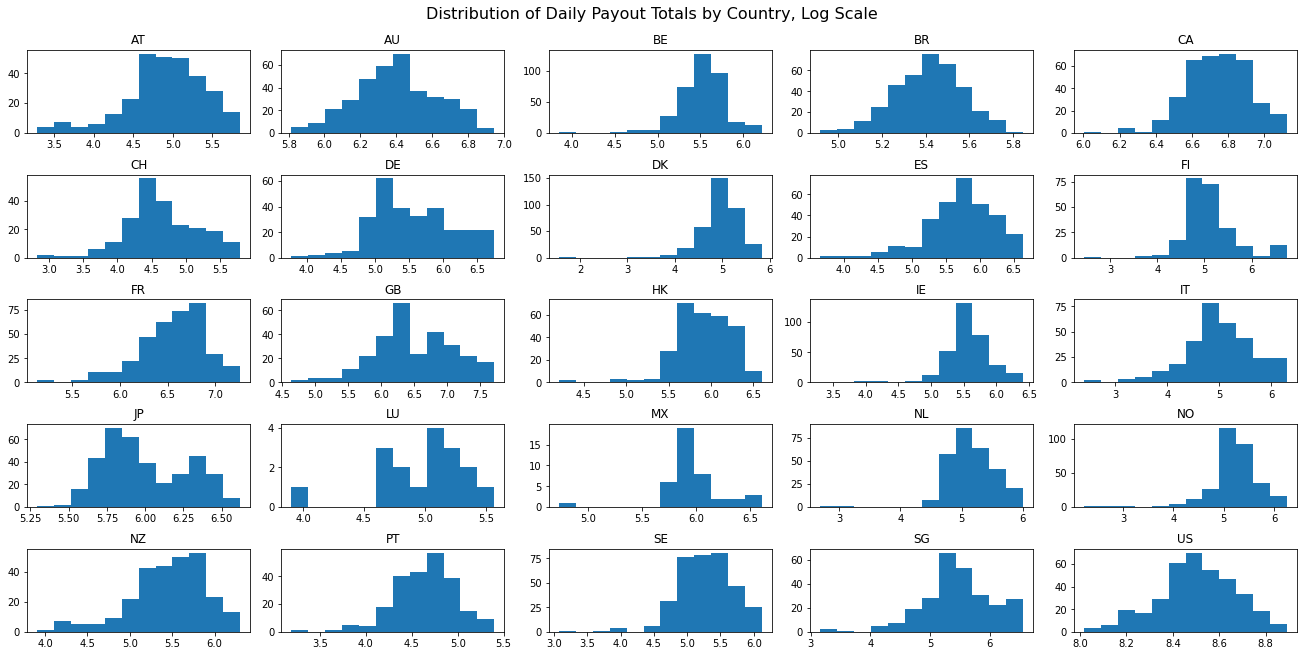

In [ ]:
log_normalized_payouts_by_country = np.log10(daily_payout_totals_by_country.apply(slice_normalize_stack, axis=0))

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Distribution of Daily Payout Totals by Country, Log Scale', fontsize=16)

for n, country_name in enumerate(log_normalized_payouts_by_country.columns):
    log_normalized_payouts = log_normalized_payouts_by_country[country_name]
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].hist(log_normalized_payouts, bins=12)

plt.show()

The log transform of this data looks much more normally distributed than the original untransformed data. Using log transformed data or a zero-inflated Poisson model may be a better choice for regression.

### Linear Model

In [ ]:
daily_payout_totals_by_country.head()

country,AT,AU,BE,BR,CA,CH,DE,DK,ES,FI,FR,GB,HK,IE,IT,JP,LU,MX,NL,NO,NZ,PT,SE,SG,US
date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,2487.0,1833517.0,183827.0,4976.0,7373215.0,0.0,5212.0,151371.0,64374.0,296200.0,1716103.0,57117.0,0.0,2681.0,21145.0,793022.0,0.0,0.0,20752.0,0.0,11597.0,0.0,614.0,0.0,184345229.0
2018-01-02 00:00:00+00:00,144687.0,918292.0,740681.0,44887.0,10551814.0,0.0,3490.0,25078.0,12681.0,0.0,824280.0,2000319.0,0.0,78374.0,32438.0,1509761.0,0.0,0.0,0.0,72149.0,3172.0,0.0,3460.0,0.0,201404716.0
2018-01-03 00:00:00+00:00,47083.0,4228035.0,190272.0,82956.0,15850354.0,0.0,47723.0,38911.0,49450.0,0.0,792592.0,587355.0,0.0,7092.0,62159.0,2899764.0,0.0,0.0,0.0,143380.0,0.0,0.0,28238.0,0.0,425615954.0
2018-01-04 00:00:00+00:00,27541.0,1751532.0,208143.0,56516.0,12493504.0,0.0,3360.0,85854.0,79711.0,4122.0,646035.0,259369.0,0.0,1140.0,23333.0,1829156.0,0.0,0.0,148591.0,35464.0,0.0,0.0,13145.0,3295.0,256007822.0
2018-01-05 00:00:00+00:00,21491.0,1122473.0,394261.0,49910.0,2433320.0,3097.0,432482.0,54836.0,13041.0,8458.0,2563230.0,281500.0,42629.0,2741539.0,28873.0,1175558.0,0.0,0.0,0.0,49843.0,11029.0,0.0,6203.0,559.0,163779300.0


I write a function to fit a linear model with the option to forecast n days into the future:

In [ ]:
def lin_reg(daily_payout_totals, forecast=0):
    # trim zeros from period of inactivity in beginning of year (mostly for LU and MX)
    daily_payout_totals = np.trim_zeros(daily_payout_totals.dropna(), trim='f') # daily_payout_totals.dropna()
    idx = daily_payout_totals.index
    new_idx = idx.append(pd.date_range(start=idx[-1], periods=1+forecast, closed='right'))
    X = (idx - idx[0]).days
    new_X = (new_idx - new_idx[0]).days
    y = daily_payout_totals.values

    model = np.polyfit(X, y, 1)
    predictions = np.polyval(model, new_X)

    daily_payout_predictions = pd.Series(predictions, index=new_idx)
    return daily_payout_predictions



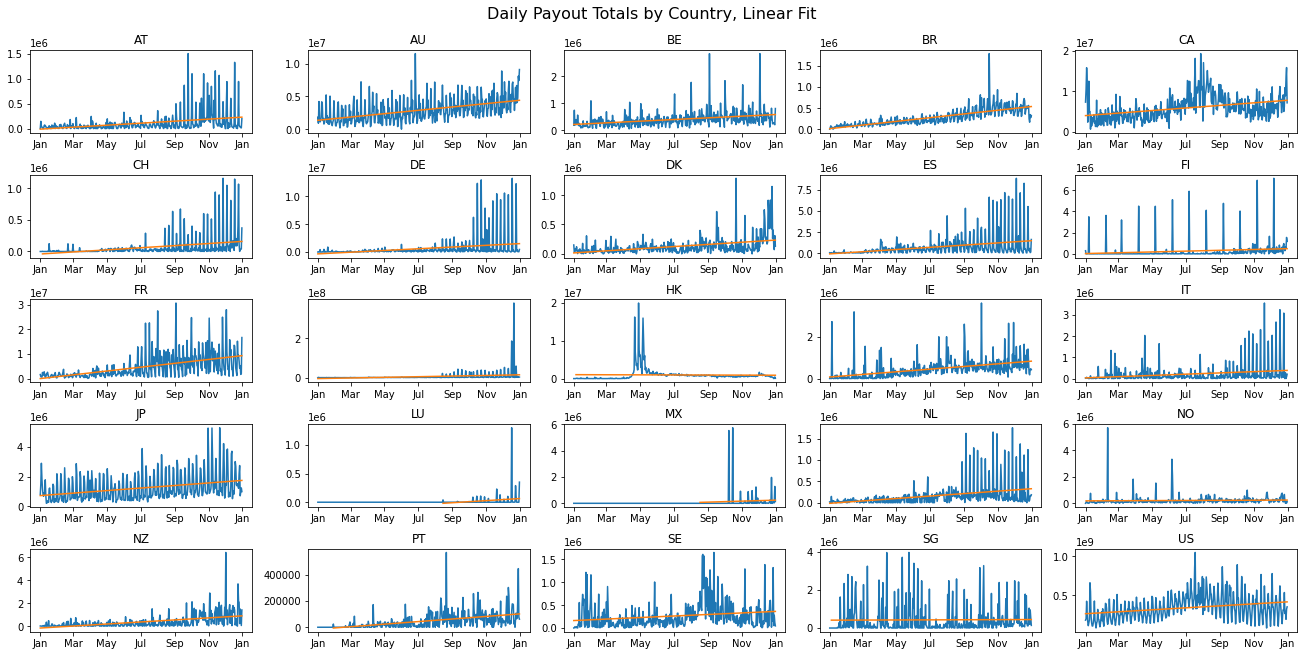

In [ ]:
# Make the date axis look nice:
from matplotlib.dates import DateFormatter
date_format = DateFormatter('%b') # -%y

daily_payout_predictions_by_country = daily_payout_totals_by_country.apply(
    lambda x: lin_reg(x, forecast=0), axis=0)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Daily Payout Totals by Country, Linear Fit', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    # formatting parameters
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].xaxis.set_major_formatter(date_format)
    # ax[r,c].tick_params(axis='x', labelrotation=35)

    # plot payouts
    daily_payouts = daily_payout_totals_by_country[country_name]
    ax[r,c].plot(daily_payouts.index, daily_payouts)

    # plot linear fit
    linear_fit = daily_payout_predictions_by_country[country_name]
    ax[r,c].plot(linear_fit.index, linear_fit)
    
plt.show()

These linear fits look okay. Let's add some prediction bands to these plots and extrapolate to tomorrow:

In [ ]:
def calc_prediction_intervals(daily_payout_totals, forecast=0, confidence=0.95):
    # trim zeros from period of inactivity in beginning of year (mostly for LU and MX)
    daily_payout_totals = np.trim_zeros(daily_payout_totals.dropna(), trim='f')
    idx = daily_payout_totals.index
    new_idx = idx.append(pd.date_range(start=idx[-1], periods=1+forecast, closed='right'))
    X = (idx - idx[0]).days
    new_X = (new_idx - new_idx[0]).days
    y = daily_payout_totals.values

    model = np.polyfit(X, y, 1)
    predictions = np.polyval(model, new_X)
    n = len(y)
    m = len(model)
    dof = n - m # degrees of freedom
    t = stats.t.ppf((1 + confidence)/2, dof)
    resids = y - predictions[:n]
    std_error = np.sqrt(np.sum(resids**2) / dof) 

    prediction_intervals = t * std_error * np.sqrt(1 + 1/n + (new_X - np.mean(X))**2 / np.sum((X - np.mean(X))**2))

    daily_payout_prediction_intervals = pd.Series(prediction_intervals, index=new_idx)
    return daily_payout_prediction_intervals

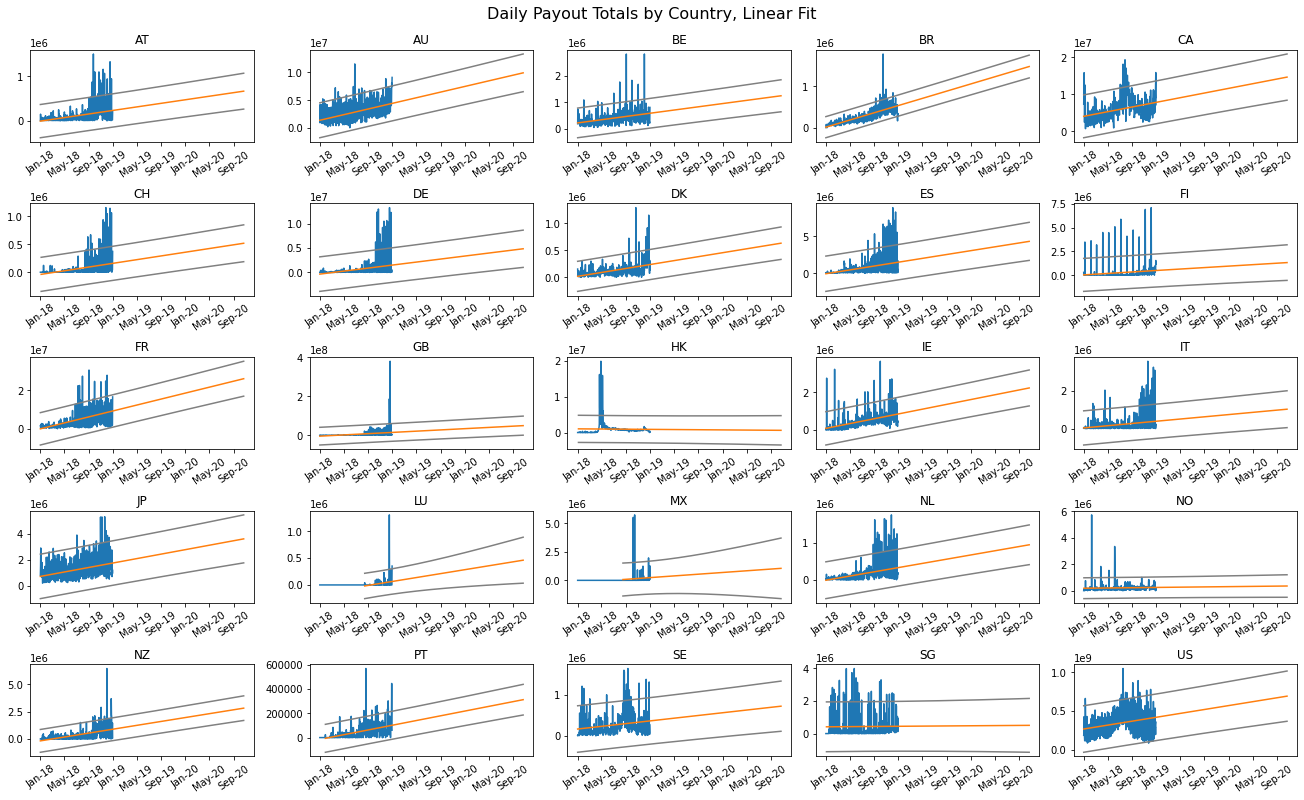

In [ ]:
# Make the date axis look nice:
from matplotlib.dates import DateFormatter
date_format = DateFormatter('%b-%y')

daily_payout_preds_by_country = daily_payout_totals_by_country.apply(
    lambda x: lin_reg(x, forecast=660), axis=0)
daily_payout_pred_ints_by_country = daily_payout_totals_by_country.apply(
    lambda x: calc_prediction_intervals(x, forecast=660, confidence=0.95), axis=0)

upper_bounds_by_country = daily_payout_preds_by_country + daily_payout_pred_ints_by_country

# Payouts can be negative!
lower_bounds_by_country = (daily_payout_preds_by_country - daily_payout_pred_ints_by_country)#.applymap(lambda x: max(x, 0))

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,11), constrained_layout=True)
fig.suptitle('Daily Payout Totals by Country, Linear Fit', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    # formatting parameters
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].xaxis.set_major_formatter(date_format)
    ax[r,c].tick_params(axis='x', labelrotation=35)

    # plot payouts
    daily_payouts = daily_payout_totals_by_country[country_name]
    ax[r,c].plot(daily_payouts.index, daily_payouts)

    # plot linear fit
    linear_fit = daily_payout_preds_by_country[country_name]
    ax[r,c].plot(linear_fit.index, linear_fit)

    # plot upper
    upper_bounds = upper_bounds_by_country[country_name]
    ax[r,c].plot(upper_bounds.index, upper_bounds, color='gray')

    # plot lower
    lower_bounds = lower_bounds_by_country[country_name]
    ax[r,c].plot(lower_bounds.index, lower_bounds, color='gray')
    
plt.show()

## Answer

According to these simple linear regressions, I could give the following table as my answer to Question 1:

In [ ]:
tomorrow = dt.datetime.today().replace(hour=0, minute=0, second=0, microsecond=0) + dt.timedelta(days=1) 
preds = daily_payout_preds_by_country.loc[tomorrow]
lowers = lower_bounds_by_country.loc[tomorrow]
uppers = upper_bounds_by_country.loc[tomorrow]
pd.DataFrame({'lower bound':lowers, 'mean':preds, 'upper bound':uppers})

,lower bound,mean,upper bound
country,,,
AT,2.484103e+05,6.506176e+05,1.052825e+06
AU,6.387005e+06,9.778797e+06,1.317059e+07
BE,6.205646e+05,1.227642e+06,1.834718e+06
BR,1.182175e+06,1.457140e+06,1.732105e+06
CA,8.245687e+06,1.447653e+07,2.070738e+07
CH,1.798896e+05,5.086657e+05,8.374418e+05
DE,9.627806e+05,4.759648e+06,8.556515e+06
DK,3.190394e+05,6.179491e+05,9.168587e+05
ES,1.660631e+06,4.217859e+06,6.775088e+06


## Steps Forward

There are many approaches I can take to improve on this simple linear extrapolation.

This whole **Steps Forward** section can be collapsed and ignored. I included it in case a hiring manager might be interested to see how I think. 

It is a list of several paths I would like to explore at a later time, but didn't have time to finish. 

*Done is better than Perfect, because Perfect ain't real.*


### Residuals

I'll start by looking at the residuals from the model:

In [ ]:
def calc_lin_reg_resids(daily_payout_totals):
    daily_payout_totals = np.trim_zeros(daily_payout_totals.dropna(), trim='f') 
    idx = daily_payout_totals.index
    X = (idx - idx[0]).days#.to_numpy().reshape(-1, 1)
    y = daily_payout_totals.values
    model = np.polyfit(X, y, 1)
    predictions = np.polyval(model, X)
    daily_payout_residuals = daily_payout_totals - predictions
    return daily_payout_residuals

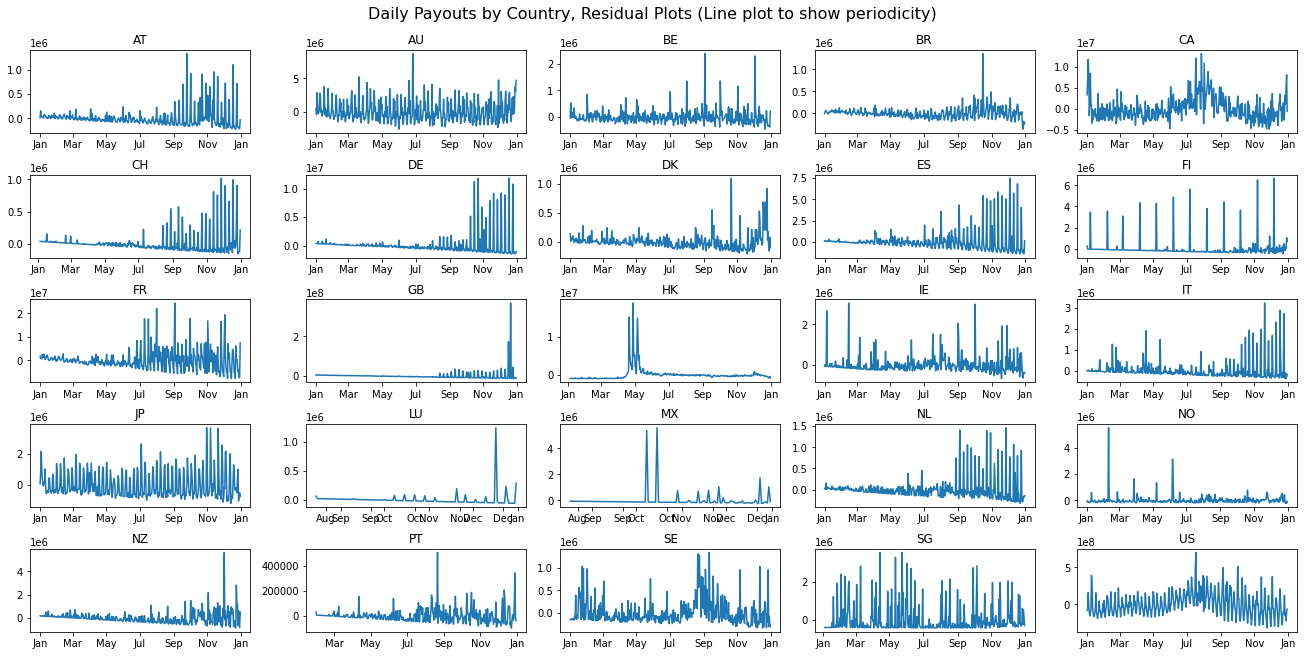

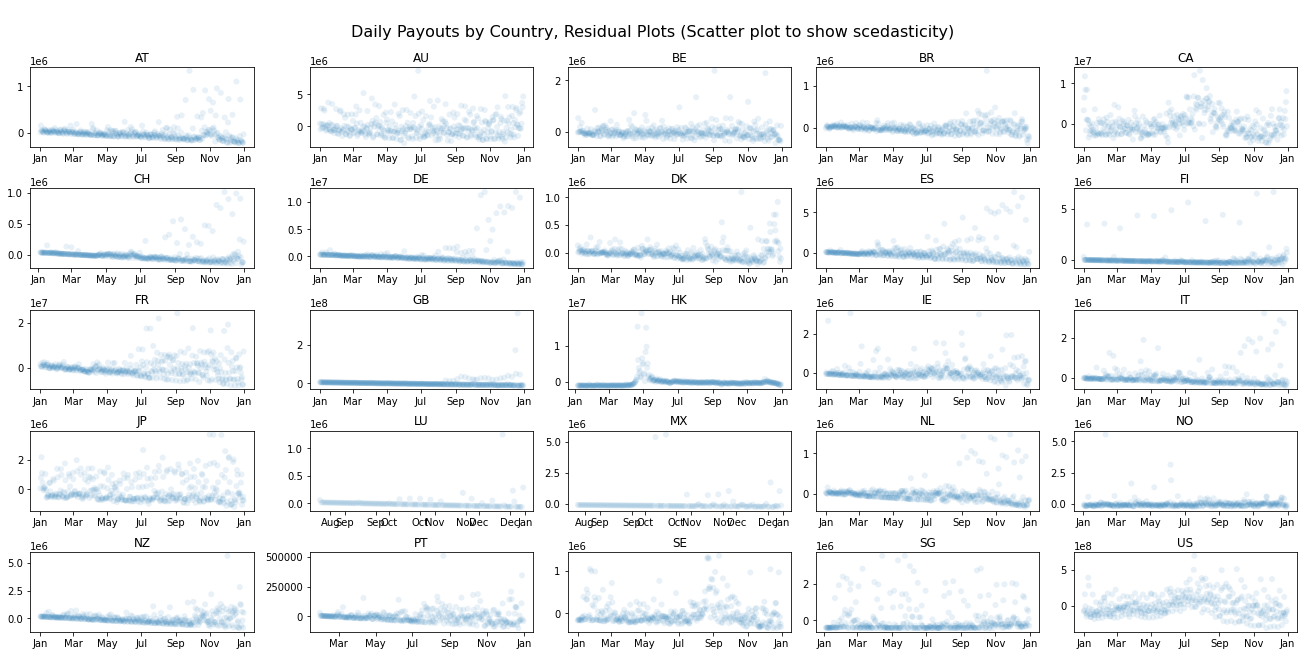

In [ ]:
# Make the date axis look nice:
from matplotlib.dates import DateFormatter
date_format = DateFormatter('%b') # -%y

payout_residuals_by_country = daily_payout_totals_by_country.apply(
    calc_lin_reg_resids, axis=0)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Daily Payouts by Country, Residual Plots (Line plot to show periodicity)', fontsize=16)

for n, country_name in enumerate(payout_residuals_by_country.columns):
    # formatting parameters
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].xaxis.set_major_formatter(date_format)
    # ax[r,c].tick_params(axis='x', labelrotation=35)

    # plot payouts
    payout_residuals = payout_residuals_by_country[country_name]
    ax[r,c].plot(payout_residuals.index, payout_residuals)
    # ax[r,c].scatter(payout_residuals.index, payout_residuals, alpha=0.1, edgecolors='none')
    
fig2, ax2 = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig2.suptitle('\nDaily Payouts by Country, Residual Plots (Scatter plot to show scedasticity)', fontsize=16)

for n, country_name in enumerate(payout_residuals_by_country.columns):
    # formatting parameters
    r,c = n//5, n%5
    ax2[r,c].set_title(country_name)
    ax2[r,c].xaxis.set_major_formatter(date_format)
    # ax[r,c].tick_params(axis='x', labelrotation=35)

    # plot payouts
    payout_residuals = payout_residuals_by_country[country_name]
    ax2[r,c].scatter(payout_residuals.index, payout_residuals, alpha=0.1, edgecolors='none')

plt.show()

These residual plots show that the residuals are heteroscedastic and have a periodic pattern to them.

### Varying Variance

 I write a function to calculate the rolling variance of the residuals:

In [ ]:

def rolling_var(daily_payout_totals, window=28):
    # trim zeros from period of inactivity in beginning of year (mostly for LU and MX)
    daily_payout_totals = np.trim_zeros(daily_payout_totals.dropna(), trim='f') # daily_payout_totals.dropna()
    idx = daily_payout_totals.index
    variance = daily_payout_totals.rolling(window).var()
    daily_payout_variance = pd.Series(variance, index=idx)
    # drop periods of zero variance, as this does not provide useful information
    return daily_payout_variance[daily_payout_variance != 0]

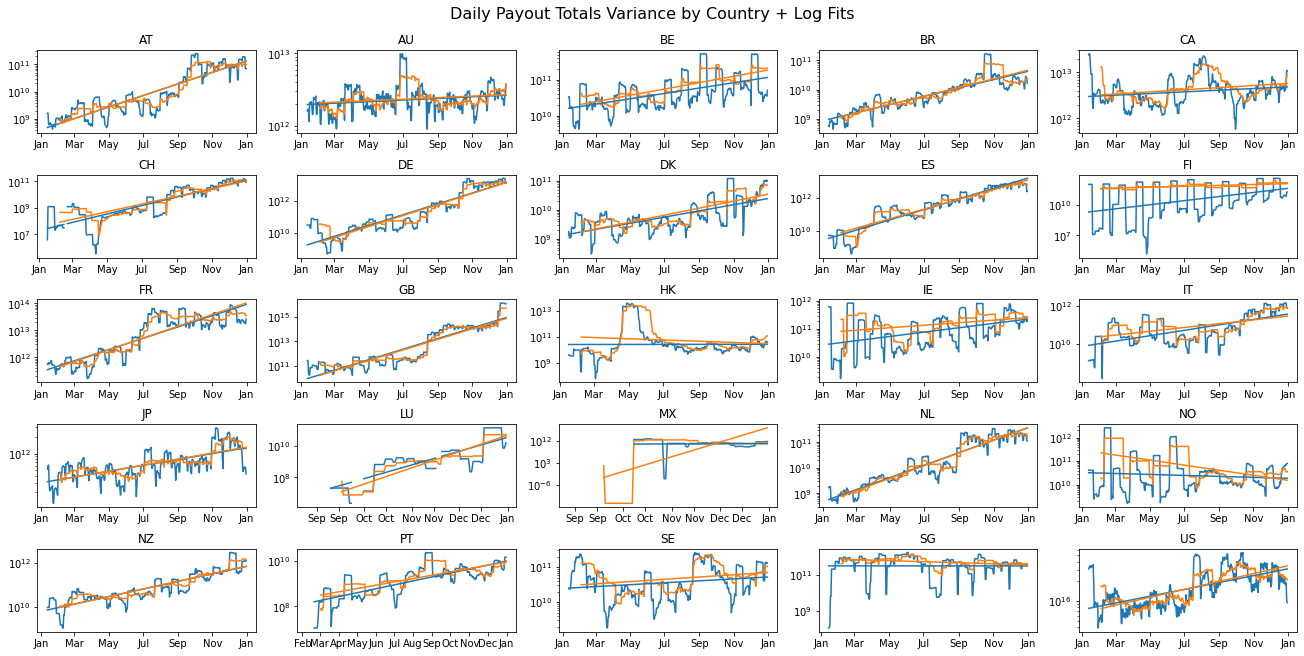

In [ ]:
# Make the date axis look nice:
from matplotlib.dates import DateFormatter
date_format = DateFormatter('%b') # -%y

daily_payout_variance_by_country1 = daily_payout_totals_by_country.apply(
    lambda x: rolling_var(x, window=12), axis=0)

daily_payout_variance_by_country2 = daily_payout_totals_by_country.apply(
    lambda x: rolling_var(x, window=34), axis=0)

log_daily_payout_variance_by_country1 = np.log10(daily_payout_variance_by_country1)
log_daily_payout_variance_by_country2 = np.log10(daily_payout_variance_by_country2)

log_variance_log_fit_by_country1 = log_daily_payout_variance_by_country1.apply(
    lambda x: lin_reg(x, forecast=0), axis=0)
log_variance_log_fit_by_country2 = log_daily_payout_variance_by_country2.apply(
    lambda x: lin_reg(x, forecast=0), axis=0)

variance_log_fit_by_country1 = np.power(10,log_variance_log_fit_by_country1)
variance_log_fit_by_country2 = np.power(10,log_variance_log_fit_by_country2)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Daily Payout Totals Variance by Country + Log Fits', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    # formatting parameters
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].xaxis.set_major_formatter(date_format)
    # ax[r,c].tick_params(axis='x', labelrotation=35)
    ax[r,c].set_yscale('log', nonposy='clip')

    # plot payout variance1
    daily_payout_variance1 = daily_payout_variance_by_country1[country_name]
    ax[r,c].plot(daily_payout_variance1.index, daily_payout_variance1, color='tab:blue')

    # plot payout variance2
    daily_payout_variance2 = daily_payout_variance_by_country2[country_name]
    ax[r,c].plot(daily_payout_variance2.index, daily_payout_variance2, color='tab:orange')

    # plot variance_log_fit1
    variance_log_fit1 = variance_log_fit_by_country1[country_name]
    ax[r,c].plot(variance_log_fit1.index, variance_log_fit1, color='tab:blue')

    # plot variance_log_fit2
    variance_log_fit2 = variance_log_fit_by_country2[country_name]
    ax[r,c].plot(variance_log_fit2.index, variance_log_fit2, color='tab:orange')

plt.show()

In most of these plots, the orange plot of variances seems to give a better visual idea of how the variance evolves over time, but the blue fitted line seems to give the best projection of variance into the future.

As for the plots with negatively sloped lines, I will use the midpoint of the fitted line, with a slope of zero to forecast the variance of each country.

### Characterizing the Seasonality

Using a multiplicative model of seasonality, I attempt to characterize seasonal component of the data by grouping by day of week and dividing out the mean seasonal anomaly.


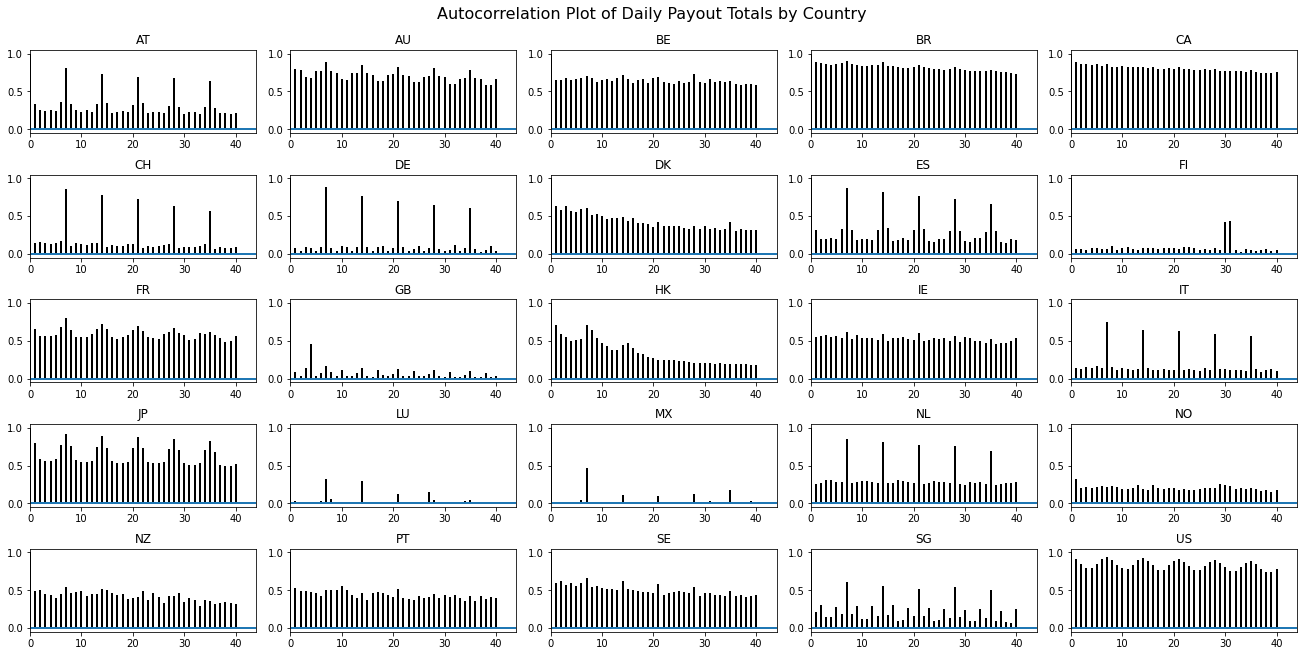

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Autocorrelation Plot of Daily Payout Totals by Country', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    sum_of_payouts_per_time = daily_payout_totals_by_country[country_name]
    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].acorr(sum_of_payouts_per_time, normed=True, maxlags=40, lw=2)
    ax[r,c].set_xlim(left=0)

plt.show()

In many of these plots, there is a strong signal of autocorrelation on a seven day basis.

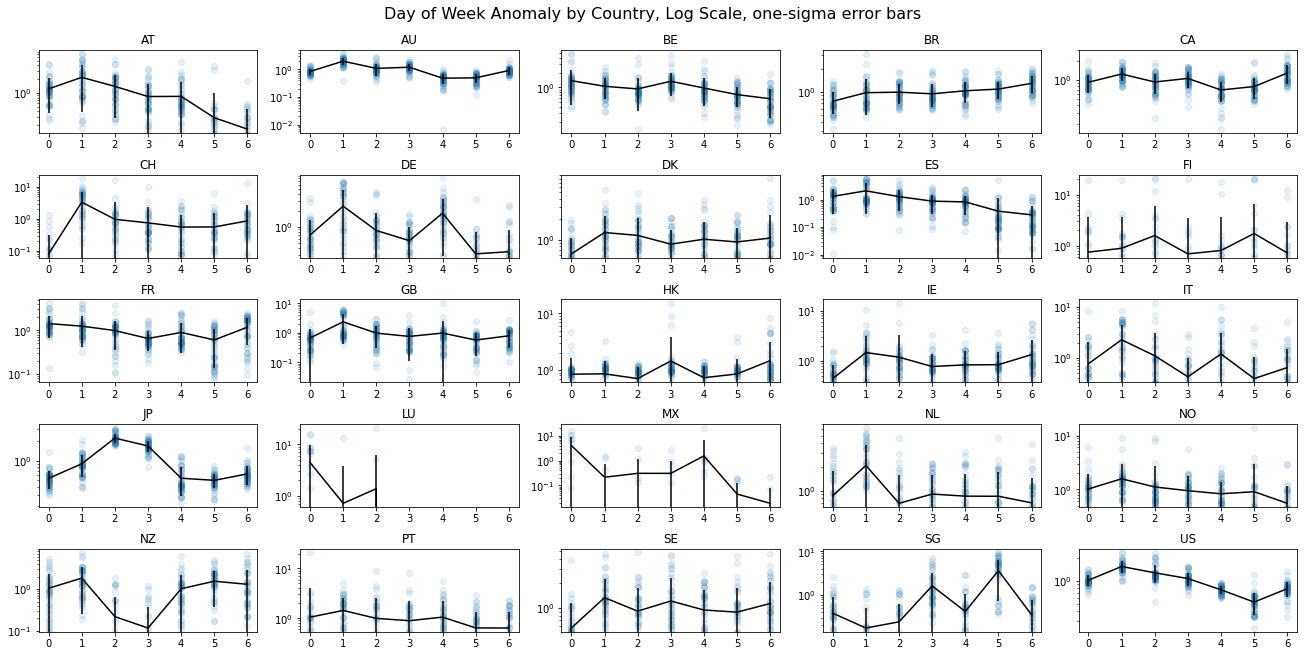

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Day of Week Anomaly by Country, Log Scale, one-sigma error bars', fontsize=16)

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    rolling_mean = daily_payout_totals_by_country[[country_name]].rolling(21, center=True).mean().dropna()
    dow_anomaly = daily_payout_totals_by_country[[country_name]] / rolling_mean
    dow_anomaly['dow'] = dow_anomaly.index.dayofweek #Monday=0, Sunday=6

    anomalies = dow_anomaly.groupby('dow')[country_name].agg([np.mean,np.std])\
        .rename({'mean':'anom_mean', 'std':'anom_std'}, axis='columns')

    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].set_yscale('log', nonposy='clip')
    ax[r,c].scatter(x=dow_anomaly['dow'], y=dow_anomaly[country_name], alpha=0.1)
    ax[r,c].errorbar(x=anomalies.index, y=anomalies['anom_mean'], yerr=anomalies['anom_std'], c='black')

plt.show()

### Deseasonalize

Have to demonstrate if identifiable seasonality is anywhere near comparable to error component. How can I compare that?

maybe evaluate error associated with each country's model of seasonality, and if it's less than some value given by some test, than it deserves to be used in the linear model as it will improve R-squared value.

Otherwise, there is no point in adding the country's model of seasonality as it will only increase the total error. 

Start by summing the residuals or the squares of the resids

### Linear Model with deseasonalized data

Extrapolate with manually deseasonalized data.

### Linear Model with Reseasonalized data

Multiply or add in the seasonality to the extrapolated model.

### SARIMA

I used 7 for the seasonality, and grid searched through values of `0`, `1`, and `2` for `p`, `d`, `q`, `P`, `D`, and `Q` in a SARIMA model. I knew grid searching through 3x3x3 x 3x3x3 x 25 countries = 18,225 SARIMA models would be pretty resource intensive, so wrote the following standalone code I could copy and paste into 8 separate simultaneous processes to take advantage of the 8 logical processors in my computer. I used the variable `cohort` to break up the task.


In [ ]:

# cohort = 0

# country_names = ['AU','BE','BR','CA','CH','DE','DK','ES',
#                  'FI','FR','GB','HK','IE','IT','JP','LU',
#                  'MX','NL','NO','NZ','PT','SE','SG','US'][cohort::8]

# import numpy as np
# import pandas as pd
# from datetime import datetime
# import warnings
# import statsmodels.api as sm
# import itertools

# warnings.filterwarnings('ignore')

# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


# for country_name in country_names:
#     print('\n',country_name)
#     df = pd.DataFrame()
#     daily_payouts = daily_payout_totals_by_country[country_name]
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             started_at = datetime.now()
#             print(f'{started_at} >> ARIMA{param}x{param_seasonal}', end=' ', flush=True)
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(daily_payouts,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)
#                 results = mod.fit()
#                 elapsed = datetime.now() - started_at
#                 df.append(pd.DataFrame({
#                     'started_at':started_at,
#                     'p':param[0],
#                     'd':param[1],
#                     'q':param[2],
#                     'sp':param_seasonal[0],
#                     'sd':param_seasonal[1],
#                     'sq':param_seasonal[2],
#                     'aic':results.aic,
#                     'elapsed':elapsed
#                     }, index=[0]), ignore_index=True)
#                 print(f'- AIC:{results.aic} ({elapsed})')
#             except:
#                 elapsed = datetime.now() - started_at
#                 df.append(pd.DataFrame({
#                     'started_at':started_at,
#                     'p':param[0],
#                     'd':param[1],
#                     'q':param[2],
#                     'sp':param_seasonal[0],
#                     'sd':param_seasonal[1],
#                     'sq':param_seasonal[2],
#                     'aic':results.aic,
#                     'elapsed':elapsed
#                     }, index=[0]), ignore_index=True)
#                 print(f'failed ({elapsed})')
#                 continue
#     df.to_csv(f'ARIMA_results_{country_name}.csv')

Example output:
```
 DE
2020-09-10 16:29:33.698121 >> ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:11579.698772890832 (0:00:00.059480)
2020-09-10 16:29:33.762651 >> ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:147472.1413381814 (0:00:00.072716)
2020-09-10 16:29:33.837386 >> ARIMA(0, 0, 0)x(0, 0, 2, 7) - AIC:10848.293438427489 (0:00:00.264568)
2020-09-10 16:29:34.103993 >> ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:10583.705153000108 (0:00:00.017130)
2020-09-10 16:29:34.123170 >> ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:10378.392004203792 (0:00:00.104801)
2020-09-10 16:29:34.230044 >> ARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC:10148.402257043683 (0:00:00.283010)
2020-09-10 16:29:34.515089 >> ARIMA(0, 0, 0)x(0, 2, 0, 7) - AIC:10591.49854609013 (0:00:00.032870)
2020-09-10 16:29:34.550745 >> ARIMA(0, 0, 0)x(0, 2, 1, 7) - AIC:10209.473296945716 (0:00:00.272222)
2020-09-10 16:29:34.825034 >> ARIMA(0, 0, 0)x(0, 2, 2, 7) - AIC:9990.444165534338 (0:00:00.730645)
2020-09-10 16:29:35.557732 >> ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:10614.245590038841 (0:00:00.053596)
2020-09-10 16:29:35.615488 >> ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:10578.550084023631 (0:00:00.067272)
2020-09-10 16:29:35.684803 >> ARIMA(0, 0, 0)x(1, 0, 2, 7) - AIC:10335.820726743344 (0:00:00.273204)
2020-09-10 16:29:35.960040 >> ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:10410.777335857843 (0:00:00.039133)
...
```

Results

In [ ]:
arima_stats = pd.read_csv('arima_stats.csv').drop(columns=['date','time','t']).dropna()
arima_stats = arima_stats[arima_stats['AIC']!='failed']
arima_stats['AIC'] = pd.to_numeric(arima_stats['AIC'])
arima_stats # (currently sorted by increasing AIC)

FileNotFoundError: ignored

Get the best (minimum AIC) SARIMA model parameters for each country:

In [ ]:
best_sarima_params = arima_stats.loc[arima_stats.groupby('country')['AIC'].idxmin()]
best_sarima_params = best_sarima_params.set_index('country')
best_sarima_params

In [ ]:
import statsmodels.api as sm
# daily_payout_totals_by_country
# best_sarima_params = best_sarima_params.drop(columns=['AIC'])

for param_group in best_sarima_params.itertuples():
    country_name = param_group[0]
    p, d, q, sP, sD, sQ, m = param_group[1:8]
    AIC = param_group[8]

    print(country_name, AIC)
    print(p, d, q, sP, sD, sQ, m)

    mod = sm.tsa.statespace.SARIMAX(
            daily_payout_totals_by_country[country_name],
            order=(p, d, q),
            seasonal_order=(sP, sD, sQ, m),
            enforce_stationarity=False,
            enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    print('\n')

Human behavior is inherently messy, as a lot of external factors indirectly contribute to the patterns we've seen in daily payout volume. The data from some countries is simply too sparse and messy, and we just need to live with that, but for others, there is clear room for improvement. Finland and Great Britain in particular show different seasonality, with seasonal effects seen at 30 and 4 days, respectively. I will re-run the grid search code with modified seasonality for these countries to see if I can get an improved model.


In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Projected Total Daily Payout Volume by Country, Log Scale, one-sigma error bars', fontsize=16)

warnings.filterwarnings('ignore')

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    param_group = best_sarima_params.loc[country_name]
    p = int(param_group['p'])
    d = int(param_group['d'])
    q = int(param_group['q'])
    sP = int(param_group['sP'])
    sD = int(param_group['sD'])
    sQ = int(param_group['sQ'])
    m = int(param_group['m'])
    AIC = param_group['AIC']

    print(country_name, AIC)
    print(p, d, q, sP, sD, sQ, m)

    mod = sm.tsa.statespace.SARIMAX(
            daily_payout_totals_by_country[country_name],
            order=(p, d, q),
            seasonal_order=(sP, sD, sQ, m),
            enforce_stationarity=False,
            enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=650)
    pred_ci = pred_uc.conf_int()

    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].set_yscale('log', nonposy='clip')
    ax[r,c].xaxis.set_major_formatter(date_format)
    ax[r,c].plot(daily_payout_totals_by_country.index, daily_payout_totals_by_country[country_name], label='observed')
    ax[r,c].plot(pred_uc.predicted_mean, label='forecast')
    ax[r,c].fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.show()

In [ ]:
import warnings

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,9), constrained_layout=True)
fig.suptitle('Projected Total Daily Payout Volume by Country, one-sigma error bars', fontsize=16)

warnings.filterwarnings('ignore')

for n, country_name in enumerate(daily_payout_totals_by_country.columns):
    param_group = best_sarima_params.loc[country_name]
    p = int(param_group['p'])
    d = int(param_group['d'])
    q = int(param_group['q'])
    sP = int(param_group['sP'])
    sD = int(param_group['sD'])
    sQ = int(param_group['sQ'])
    m = int(param_group['m'])
    AIC = param_group['AIC']

    print(country_name, AIC)
    print(p, d, q, sP, sD, sQ, m)

    mod = sm.tsa.statespace.SARIMAX(
            daily_payout_totals_by_country[country_name],
            order=(p, d, q),
            seasonal_order=(sP, sD, sQ, m),
            enforce_stationarity=False,
            enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=650)
    pred_ci = pred_uc.conf_int()

    r,c = n//5, n%5
    ax[r,c].set_title(country_name)
    ax[r,c].xaxis.set_major_formatter(date_format)
    ax[r,c].plot(daily_payout_totals_by_country.index, daily_payout_totals_by_country[country_name], label='observed')
    ax[r,c].plot(pred_uc.predicted_mean, label='forecast')
    ax[r,c].fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)


plt.show()

# Question 2 - Expected daily payout volume by industry

*Assume that one year from now, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day, from these three industries?*


### Setup and Data Cleanup

I begin by joining the `payouts` and `industries` tables. 

In [ ]:
df = payouts.merge(industries, how='left', left_on='recipient_id', right_on='merchant_id')
df

,date,platform_id,recipient_id,count,amount,merchant_id,industry
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0,id_23d90ec275370c686dedd7dc1c5e93b3,"Tickets: concerts,sports,movies,conventions"
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0,id_72f05535ba5e6e5b141db6b5c1f1b13b,Other Software & Content
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0,id_d70e8046fe5583e1154b2e077133e27c,Content
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0,id_1a336bd21b4bfd9810e0510e1a5f7ec2,Non-profit
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0,id_c577aeddec71607ec0be1f94bef025da,Non-profit
...,...,...,...,...,...,...,...
1622637,2018-08-02 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_e4dff590a6728c8c27a35203f9443c58,1,26284.0,id_e4dff590a6728c8c27a35203f9443c58,"Tickets: concerts,sports,movies,conventions"
1622638,2018-12-18 00:00:00+00:00,id_4fbd94bb830c62816abb07d6544bd707,id_c37e45a5b586f8fda03482b553885e81,1,8632.0,id_c37e45a5b586f8fda03482b553885e81,Other Services
1622639,2018-04-04 00:00:00+00:00,id_296420e88b94f7b67b7bb305ac82a0e4,id_e027ff25aae5b91268d99907710de5c1,1,33243.0,id_e027ff25aae5b91268d99907710de5c1,Food & Beverage
1622640,2018-07-19 00:00:00+00:00,id_48ba75d17cfea6d24ca5ba8dd72559a0,id_39a6f54346d9c62050ea03fad9693f8f,1,11882.0,id_39a6f54346d9c62050ea03fad9693f8f,Education


I define a function to help specify the missing values in the `industry` column, and then do some reformatting. 

In [ ]:
def fix_industries(row):
    merch = row['merchant_id']
    ind = row['industry']
    if pd.isna(ind):
        if pd.isna(merch):
            ind = 'Unknown'
        else:
            ind = 'Blank'
    return ind

df['fixed industries'] = df.apply(fix_industries, axis=1)

# drop 'merchant_id' and 'industry'
# rename 'fixed industries' to 'industry' and 'recipient_id' to 'merchant_id'

df = df.drop(columns=['merchant_id','industry'])
df = df.rename(columns={'fixed industries':'industry', 'recipient_id':'merchant_id'})
df

,date,platform_id,merchant_id,count,amount,industry
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0,"Tickets: concerts,sports,movies,conventions"
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0,Other Software & Content
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0,Content
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0,Non-profit
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0,Non-profit
...,...,...,...,...,...,...
1622637,2018-08-02 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_e4dff590a6728c8c27a35203f9443c58,1,26284.0,"Tickets: concerts,sports,movies,conventions"
1622638,2018-12-18 00:00:00+00:00,id_4fbd94bb830c62816abb07d6544bd707,id_c37e45a5b586f8fda03482b553885e81,1,8632.0,Other Services
1622639,2018-04-04 00:00:00+00:00,id_296420e88b94f7b67b7bb305ac82a0e4,id_e027ff25aae5b91268d99907710de5c1,1,33243.0,Food & Beverage
1622640,2018-07-19 00:00:00+00:00,id_48ba75d17cfea6d24ca5ba8dd72559a0,id_39a6f54346d9c62050ea03fad9693f8f,1,11882.0,Education


### EDA

In [ ]:
df

,date,platform_id,merchant_id,count,amount,industry
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0,"Tickets: concerts,sports,movies,conventions"
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0,Other Software & Content
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0,Content
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0,Non-profit
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0,Non-profit
...,...,...,...,...,...,...
1622637,2018-08-02 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_e4dff590a6728c8c27a35203f9443c58,1,26284.0,"Tickets: concerts,sports,movies,conventions"
1622638,2018-12-18 00:00:00+00:00,id_4fbd94bb830c62816abb07d6544bd707,id_c37e45a5b586f8fda03482b553885e81,1,8632.0,Other Services
1622639,2018-04-04 00:00:00+00:00,id_296420e88b94f7b67b7bb305ac82a0e4,id_e027ff25aae5b91268d99907710de5c1,1,33243.0,Food & Beverage
1622640,2018-07-19 00:00:00+00:00,id_48ba75d17cfea6d24ca5ba8dd72559a0,id_39a6f54346d9c62050ea03fad9693f8f,1,11882.0,Education


A challenge with Question 2 is that `industry` is specified by `merchant_id`, not `platform_id`, thus merchants from more than one industry could operate on the same platform, meaning that a platform could support more than one industry. 

In the following cells, I explore the strength of the relationship between industries and platforms:

I group and arrange the data by industry and platform:

In [ ]:
all_industries = df['industry'].unique()
all_platforms = df['platform_id'].unique()

#                                 columns          indices             columns     indices
idx = pd.MultiIndex.from_product([all_industries, all_platforms], names=['industry', 'platform_id'])
# building an index with all combinations of platforms and industry

#                                            columns     indices         body           agg
total_payouts_by_ind_and_plat = df.groupby(['industry', 'platform_id'])['amount'].apply(sum)

# reindexing and filling blanks with 0 to account for platforms that 
# may not have had any payouts to merchants of certain industries
total_payouts_by_ind_and_plat = total_payouts_by_ind_and_plat.reindex(index=idx, fill_value=0)

# unstacking the data into a dataframe
total_payouts_by_ind_and_plat = total_payouts_by_ind_and_plat.unstack(level=0)

And then write a function to rank the top industries of each platform by payout volume.

In [ ]:
def rank_industries(plat):
    pct = plat.abs().sort_values(ascending=False) / plat.abs().sum()
    ind = pct.index
    cols = ['Ind1', 'Ind1_pct', 'Ind2', 'Ind2_pct', 'Ind2_sum_pct', 'Ind3', 'Ind3_pct', 'Ind3_sum_pct']
    data = [ind[0], pct[0],     ind[1], pct[1],     pct[0]+pct[1],  ind[2], pct[2],     pct[0]+pct[1]+pct[2]]
    return pd.Series(data, index=cols)

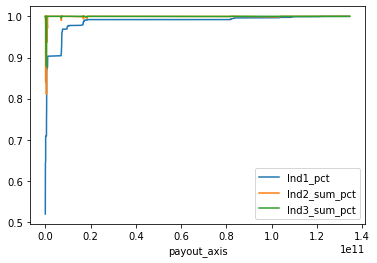

In [ ]:
industry_percents = total_payouts_by_ind_and_plat.apply(rank_industries, axis=1)

# sort by strength of top industry
ind_pcts_sorted = industry_percents.sort_values(['Ind1_pct'])

#  make key with total payout volumes by platform and join
platform_payout_volumes = df.groupby('platform_id')['amount'].sum()
ind_pcts_sorted = ind_pcts_sorted.merge(platform_payout_volumes,how='left',left_index=True,right_index=True)

# calculate cumulative sum of payout volumes to use as payout axis
ind_pcts_sorted['payout_axis'] = ind_pcts_sorted['amount'].cumsum()
ind_pcts_sorted[['payout_axis','Ind1_pct','Ind2_sum_pct','Ind3_sum_pct']].plot('payout_axis')

The area below the blue curve corresponds to how confidently I might classify a platform according to its top industry.

In [ ]:
(ind_pcts_sorted['Ind1_pct']*ind_pcts_sorted['amount']).sum() / ind_pcts_sorted['amount'].sum()

0.9875019258069259

98.8% of all platform payout volume analyzed can be correctly assumed to pertain to the most common industry for that platform.


### Forecasting

The number of platforms for each industry in 2018:

In [ ]:
df.groupby('industry')['platform_id'].apply(lambda x: len(set(x)))

industry
Content                                                5
Direct Services: classes,memberships,appointments      9
Education                                              7
Food & Beverage                                       17
Healthcare                                             6
Non-profit                                            18
Other Retail                                          12
Other Services                                        74
Other Software & Content                             251
Professional Services (non-medical)                   21
Retail Fashion                                        11
Tickets: concerts,sports,movies,conventions            6
Travel & Hospitality                                   9
Unknown                                              276
Name: platform_id, dtype: int64

Question 2 specifies "15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage". In 2018, there were 7 platforms from the Education industry, 17 from Food & Beverage, and **0** platforms from Hotels, Restaurants & Leisure. 

Since there is no data available for Hotels, Restaurants & Leisure, I will assume that data from Travel & Hospitality can be used as a proxy.

The following function shows the distribution of payout volume by platform for a given industry:

In [ ]:
def plat_payout_dist_by_qtr(df, industry, figsize=(18,2.5)):
    df_filtered = df[df['industry']==industry]
    all_platforms = df_filtered['platform_id'].unique()
    all_dates = pd.date_range(freq='Q', start=df['date'].min(), end=df['date'].max())
    date_groups = pd.Grouper(key='date',freq='Q', closed='right', label='right', convention='end')

    #                                 columns      indices             columns     indices
    idx = pd.MultiIndex.from_product([all_dates, all_platforms], names=['date', 'platform_id'])
    # building an index with all combinations of platforms and industry

    #                                                  columns        indices         body           agg
    quarterly_platform_payouts = df_filtered.groupby([date_groups, 'platform_id'])['amount'].apply(sum)

    # reindexing and filling blanks with 0 to account for platforms that 
    # may not have had any payouts during certain quarters
    quarterly_platform_payouts = quarterly_platform_payouts.reindex(index=idx, fill_value=0)

    # unstacking the data into a dataframe
    quarterly_platform_payouts = quarterly_platform_payouts.unstack(level=0)

    plot_rows, plot_cols = 1, 5
    col_names = {date:f'Q{n+1}' for n,date in enumerate(all_dates)}

    # give the quarter columns nicer names
    quarterly_platform_payouts_nice = quarterly_platform_payouts.rename(
        columns=col_names,
        index={plat:chr(97+n) for n,plat in enumerate(all_platforms)})
    
    # add column for total year
    quarterly_platform_payouts['Year'] = quarterly_platform_payouts.sum(axis=1)
    quarterly_platform_payouts_nice['Year'] = quarterly_platform_payouts_nice.sum(axis=1)

    fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=figsize, constrained_layout=True)
    fig.suptitle(f'Distribution of Platform Payouts, {industry}', fontsize=15)

    for n, quarter in enumerate(quarterly_platform_payouts_nice.columns):
        platform_payouts = quarterly_platform_payouts_nice[quarter].sort_values(ascending=False)
        r,c = n//plot_rows, n%plot_cols
        ax[c].set_title(quarter)
        ax[c].bar(platform_payouts.index, platform_payouts, width=1)
    plt.show()

    return quarterly_platform_payouts

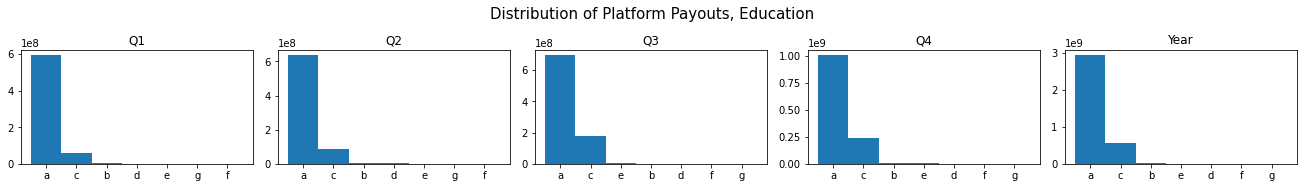

In [ ]:
industry = 'Education'
_ = plat_payout_dist_by_qtr(df, industry)

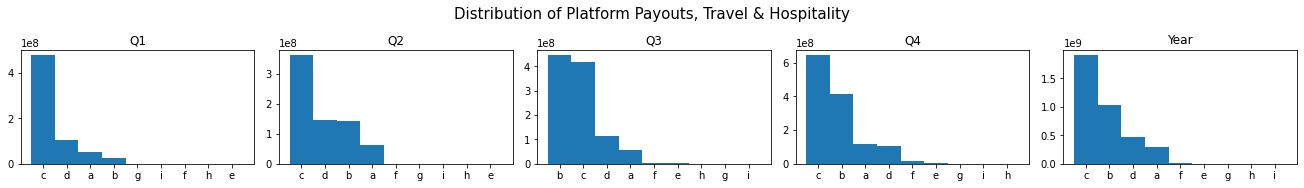

In [ ]:
industry = 'Travel & Hospitality'
_ = plat_payout_dist_by_qtr(df, industry)

Note that `Travel & Hospitality` has the "broadest" distribution of the three industries we're looking at, and will therefore provide a more reliable estimate of the expected volume of payouts of a platform focused on the `Hotels, Restaurants & Leisure` industry, which will be used to forecast the payout volume for the 5 platforms in the `Hotels, Restaurants & Leisure` industry.

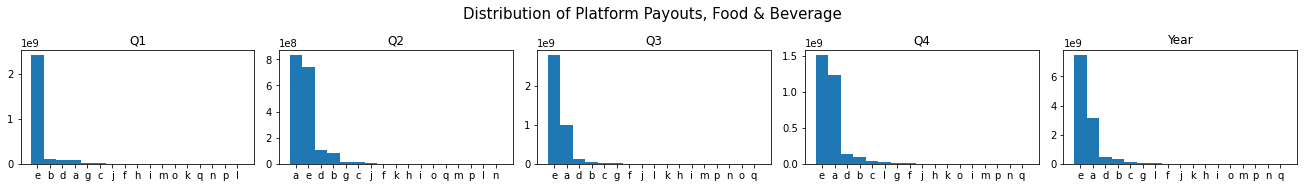

In [ ]:
industry = 'Food & Beverage'
_ = plat_payout_dist_by_qtr(df, industry)

The following function shows the weekly evolution of the distribution of payout volume by platform for a given industry:

In [ ]:
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%b")

def plat_payouts_plot(df, industry, figsize=(9,5)):
    df_filtered = df[df['industry']==industry]
    all_platforms = df_filtered['platform_id'].unique()
    all_dates = pd.date_range(freq='W-MON', start=df['date'].min(), end=df['date'].max())
    date_groups = pd.Grouper(key='date',freq='W-MON', closed='left', label='left', convention='start')
    date_format = DateFormatter("%b")

    # build index with all combos of   columns    &   indices             columns       indices
    idx = pd.MultiIndex.from_product([all_platforms, all_dates], names=['platform_id', 'date'])
    # building an index with all combinations of platforms and weeks

    #                                                  columns        indices        body          agg
    weekly_payouts_by_platform = df_filtered.groupby(['platform_id', date_groups])['amount'].apply(sum)

    # reindexing and filling blanks with 0 to account for platforms that 
    # may not have had any payouts during certain weeks
    weekly_payouts_by_platform = weekly_payouts_by_platform.reindex(index=idx, fill_value=0)

    # unstacking the data into a dataframe
    weekly_payouts_by_platform = weekly_payouts_by_platform.unstack(level=0)

    # reorder columns so the platform with the largest payouts is plotted last 
    col_order = weekly_payouts_by_platform.sum(axis=0).sort_values(ascending=True).index.to_list()
    weekly_payouts_by_platform = weekly_payouts_by_platform[col_order]

    # calculate cumulative sum to stack lines
    # give the platform columns nicer names
    weekly_payouts_by_platform_cumulative = weekly_payouts_by_platform\
                .cumsum(axis=1)\
                .drop(index=weekly_payouts_by_platform.index[-1])\
                .rename(columns={plat:chr(97+n) for n,plat in enumerate(all_platforms)})

    weekly_preds_by_platform_cumulative = weekly_payouts_by_platform_cumulative.apply(lin_reg)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, constrained_layout=True)
    fig.suptitle(f'Evolution of Platform Payouts, {industry} (Stacked Line Plot)', fontsize=14)

    for plat in weekly_payouts_by_platform_cumulative.columns[::-1]:
        platform_payouts_cumulative = weekly_payouts_by_platform_cumulative[plat]
        platform_preds_cumulative = weekly_preds_by_platform_cumulative[plat]
        ax.plot(platform_preds_cumulative.index, platform_preds_cumulative, label=None, color='lightgray')
        ax.plot(platform_payouts_cumulative.index, platform_payouts_cumulative, label=plat)
        ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    plt.show()

    return weekly_payouts_by_platform

I update my `lin_reg` function:

In [ ]:
def lin_reg(daily_payouts, forecast=0):
    idx = daily_payouts.index
    new_idx = idx.append(pd.date_range(start=idx[-1], periods=1+forecast, closed='right', freq='D'))
    X = (idx - idx[0]).days
    new_X = (new_idx - new_idx[0]).days
    y = daily_payouts.values

    model = np.polyfit(X, y, 1)
    predictions = np.polyval(model, new_X)

    daily_payout_preds = pd.Series(predictions, index=new_idx)
    return daily_payout_preds

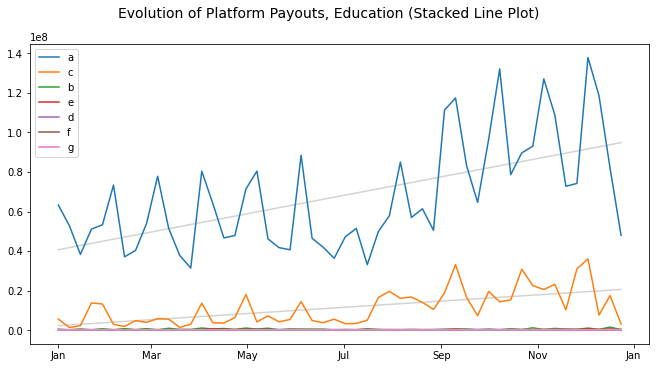

In [ ]:
industry = 'Education'
_ = plat_payouts_plot(df, industry, figsize=(9, 5))

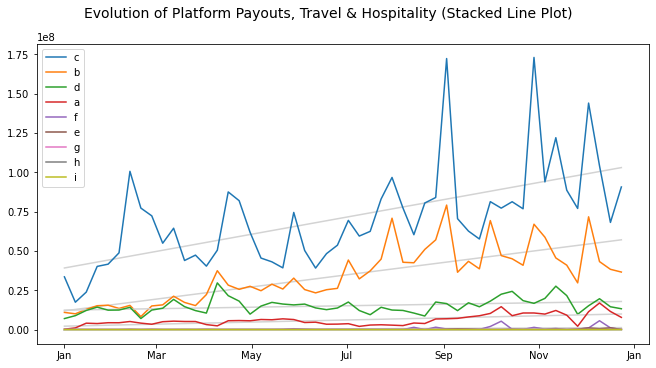

In [ ]:
industry = 'Travel & Hospitality'
_ = plat_payouts_plot(df, industry, figsize=(9, 5))

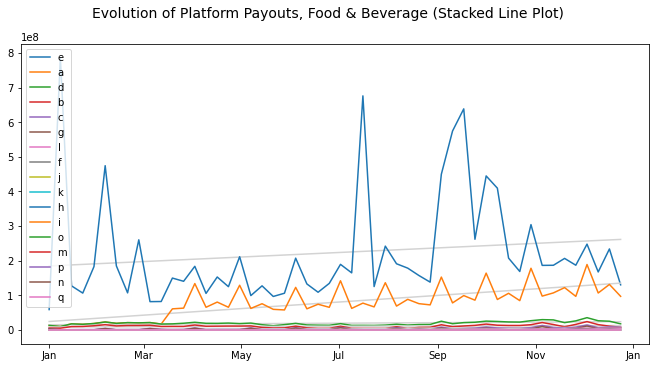

In [ ]:
industry = 'Food & Beverage'
_ = plat_payouts_plot(df, industry, figsize=(9, 5))

## HA HA HA. Okay, you got me. 
The number of platforms shouldn't matter in Zipfian-like distribution. The top few platforms should dominate the payout volume. Adding a new platform* will not appreciably change payout volume. Payout volume is better predicted by volume history and not the number of platforms! However, since this is just a hunch, I'll prove it in the next few cells:

<sup>*that starts out and grows organically with Stripe</sup>




### Distributions and Expected Value

I define a function to perform a logarithmic regression:

In [ ]:
def log_reg(platform_payouts, forecast=0):
    idx = platform_payouts.index
    new_idx = idx.append(pd.RangeIndex.from_range(range(idx[-1]+1,idx[-1]+1+forecast)))
    
    log_platform_payouts = np.log(platform_payouts)
    # log_idx = np.log(idx)
    # log_new_idx = np.log(new_idx)
    
    X = idx
    new_X = new_idx
    y = log_platform_payouts.values

    model = np.polyfit(X, y, 1)
    log_predictions = np.polyval(model, new_X)

    predictions = np.exp(log_predictions)

    platform_payout_preds = pd.Series(predictions, index=new_idx)
    return platform_payout_preds

Then I calculate the expected value for each platform:

In [ ]:
industries = ['Education', 'Travel & Hospitality', 'Food & Beverage']
new_plat_counts = {'Education':15, 'Travel & Hospitality':5, 'Food & Beverage':40}

dict_of_platform_payouts = dict()
dict_of_platform_preds = dict()

for industry in industries:
    
    df_filtered = df[df['industry']==industry]#############################################33
    platform_payouts = df_filtered.groupby('platform_id')['amount'].apply(sum)
    platform_payouts = platform_payouts.sort_values(ascending=False).reset_index(drop=True)
    platform_payouts.index += 1

    num_platforms_to_add = new_plat_counts[industry] - len(platform_payouts)

    platform_preds = log_reg(platform_payouts, forecast=num_platforms_to_add)

    # store in dict
    dict_of_platform_payouts[industry] = platform_payouts
    dict_of_platform_preds[industry] = platform_preds

And plot them to get an idea of how the fit looks:

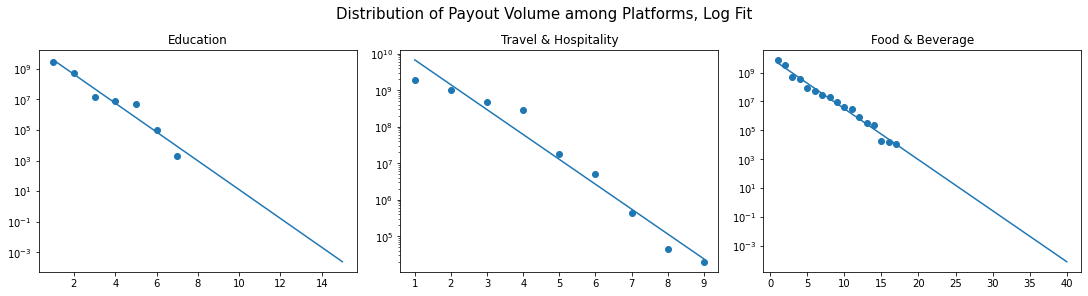

In [ ]:
plot_rows, plot_cols = 1, 3
fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(15,4), constrained_layout=True)
fig.suptitle(f'Distribution of Payout Volume among Platforms, Log Fit', fontsize=15)

for n, ind in enumerate(industries):
    r,c = n//plot_rows, n%plot_cols
    ax[c].set_title(ind)
    ax[c].set_yscale("log", nonposy='clip')

    platform_payouts = dict_of_platform_payouts[ind]
    ax[c].scatter(platform_payouts.index, platform_payouts)
    
    platform_preds = dict_of_platform_preds[ind]
    ax[c].plot(platform_preds.index, platform_preds)

plt.show()

It's striking how linear these points are!

The way to do this is to use the 2018 platform distribution to estimate how a change in the number of platforms would change the 2018 payout volume, and then use the growth rate of that modified volume to extrapolate to 2021.

So I'll first find the expected value of the changed number of platforms:

In [ ]:
changes_in_industry_payout_volume = dict()

for industry in industries:
    platform_payouts = dict_of_platform_payouts[industry]
    old_plat_count = len(platform_payouts)

    platform_preds = dict_of_platform_preds[industry]
    new_plat_count = new_plat_counts[industry]

    expected_old_plat_payouts = platform_preds[0:old_plat_count]
    expected_new_plat_payouts = platform_preds[0:new_plat_count]

    changes_in_industry_payout_volume[industry] = sum(expected_new_plat_payouts) / sum(expected_old_plat_payouts)

changes_in_industry_payout_volume

{'Education': 1.0000002524779317,
 'Food & Beverage': 1.000001008927388,
 'Travel & Hospitality': 0.9996099726097661}

Well, that settles it. For a logarithmic distribution like these, the number of platforms is poor variable for measuring change in payout volume.

### Linear Model


I arrange the payout data into total daily volume for the `Education`, `Travel & Hospitality`, and `Food & Beverage` industries, and then apply the `lin_reg` function to get forecasted values. Finally I plot the original data and the linear fits.

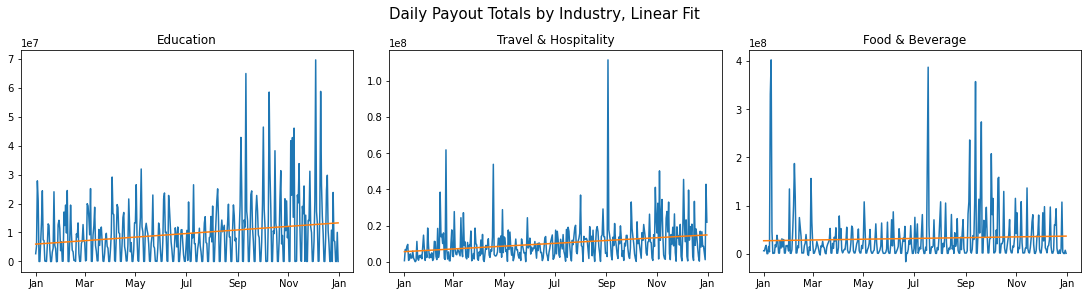

In [ ]:
industries = ['Education', 'Travel & Hospitality', 'Food & Beverage']
    
temp_dict_of_daily_payouts = dict()

for industry in industries:
    df_filtered = df[df['industry']==industry]
    all_platforms = df_filtered['platform_id'].unique()
    all_dates = pd.date_range(freq='D', start=df['date'].min(), end=df['date'].max())
    date_groups = pd.Grouper(key='date',freq='D', closed='left', label='left', convention='start')
    date_format = DateFormatter("%b")

    # build index with all combos of   columns    &   indices             columns       indices
    idx = pd.MultiIndex.from_product([all_platforms, all_dates], names=['platform_id', 'date'])
    # building an index with all combinations of platforms and days

    #                                                  columns        indices        body          agg
    daily_payouts_by_platform = df_filtered.groupby(['platform_id', date_groups])['amount'].apply(sum)

    # reindexing and filling blanks with 0 to account for platforms that 
    # may not have had any payouts during certain days
    daily_payouts_by_platform = daily_payouts_by_platform.reindex(index=idx, fill_value=0)

    # unstacking the data into a dataframe
    daily_payouts_by_platform = daily_payouts_by_platform.unstack(level=0)

    # sum across platforms
    daily_payouts = daily_payouts_by_platform.sum(axis=1)

    # store in temp var
    temp_dict_of_daily_payouts[industry] = daily_payouts

# Total daily payout volume arranged by industry:
daily_payouts_by_ind = pd.DataFrame(data=temp_dict_of_daily_payouts)

# And its linear fit:
daily_preds_by_ind = daily_payouts_by_ind.apply(lambda x: lin_reg(x, forecast=0), axis=0)

plot_rows, plot_cols = 1, 3
fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(15,4), constrained_layout=True)
fig.suptitle(f'Daily Payout Totals by Industry, Linear Fit', fontsize=15)

for n, ind in enumerate(daily_payouts_by_ind.columns):
    r,c = n//plot_rows, n%plot_cols
    ax[c].set_title(ind)
    ax[c].xaxis.set_major_formatter(date_format)

    daily_payouts = daily_payouts_by_ind[ind]
    ax[c].plot(daily_payouts.index, daily_payouts)

    daily_preds = daily_preds_by_ind[ind]
    ax[c].plot(daily_preds.index, daily_preds)

plt.show()

Let's put some prediction interval bands on these plots:

In [ ]:
def calc_prediction_intervals(daily_payouts, forecast=0, confidence=0.95):
    idx = daily_payouts.index
    new_idx = idx.append(pd.date_range(start=idx[-1], periods=1+forecast, closed='right', freq='D'))
    X = (idx - idx[0]).days
    new_X = (new_idx - new_idx[0]).days
    y = daily_payouts.values

    model = np.polyfit(X, y, 1)
    predictions = np.polyval(model, new_X)
    n = len(y)
    m = len(model)
    dof = n - m # degrees of freedom
    t = stats.t.ppf((1 + confidence)/2, dof)
    resids = y - predictions[:n]
    std_error = np.sqrt(np.sum(resids**2) / dof) 

    prediction_intervals = t * std_error * np.sqrt(1 + 1/n + (new_X - np.mean(X))**2 / np.sum((X - np.mean(X))**2))

    daily_payout_prediction_intervals = pd.Series(prediction_intervals, index=new_idx)
    return daily_payout_prediction_intervals

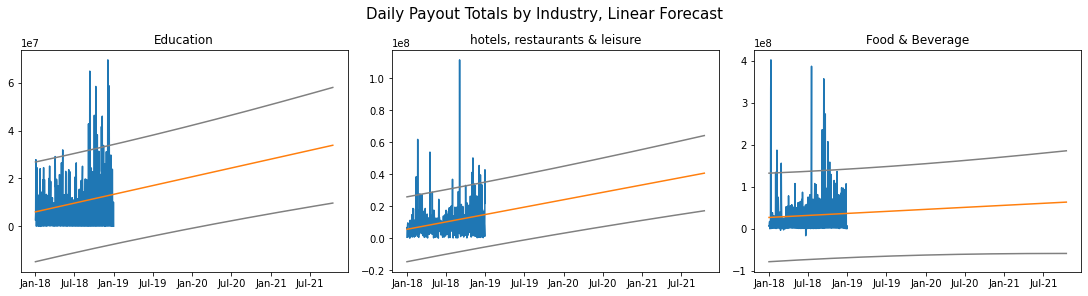

In [ ]:
date_format = DateFormatter('%b-%y')

daily_payouts_by_ind = daily_payouts_by_ind.rename(columns={'Travel & Hospitality': 'hotels, restaurants & leisure'})
daily_preds_by_ind = daily_preds_by_ind.rename(columns={'Travel & Hospitality': 'hotels, restaurants & leisure'})

# Linear Fit:
daily_preds_by_ind = daily_payouts_by_ind.apply(lambda x: lin_reg(x, forecast=1020), axis=0)

# Prediction Intervals:
daily_pred_ints_by_ind = daily_payouts_by_ind.apply(lambda x: calc_prediction_intervals(x, forecast=1020, confidence=0.95), axis=0)

upper_bounds_by_ind = daily_preds_by_ind + daily_pred_ints_by_ind

# Payouts can be negative!
lower_bounds_by_ind = (daily_preds_by_ind - daily_pred_ints_by_ind)#.applymap(lambda x: max(x, 0))

plot_rows, plot_cols = 1, 3
fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(15,4), constrained_layout=True)
fig.suptitle(f'Daily Payout Totals by Industry, Linear Forecast', fontsize=15)

for n, ind in enumerate(daily_payouts_by_ind.columns):
    r,c = n//plot_rows, n%plot_cols
    ax[c].set_title(ind)
    ax[c].xaxis.set_major_formatter(date_format)

    daily_payouts = daily_payouts_by_ind[ind]
    ax[c].plot(daily_payouts.index, daily_payouts)

    daily_preds = daily_preds_by_ind[ind]
    ax[c].plot(daily_preds.index, daily_preds)

    upper_bound = upper_bounds_by_ind[ind]
    ax[c].plot(upper_bound.index, upper_bound, color='gray')

    lower_bound = lower_bounds_by_ind[ind]
    ax[c].plot(lower_bound.index, lower_bound, color='gray')

plt.show()

## Answer

With these plots, I can extrapolate the expected payout volume for these industries to 95% confidence.

In [ ]:
a_year_from_now = dt.datetime.today().replace(hour=0, minute=0, second=0, microsecond=0) + dt.timedelta(days=365) 
preds = daily_preds_by_ind.loc[a_year_from_now]
lowers = lower_bounds_by_ind.loc[a_year_from_now]
uppers = upper_bounds_by_ind.loc[a_year_from_now]
pd.DataFrame({'lower bound':lowers, 'mean':preds, 'upper bound':uppers})

,lower bound,mean,upper bound
Education,9.457936e+06,3.357310e+07,5.768827e+07
"hotels, restaurants & leisure",1.686581e+07,4.032220e+07,6.377859e+07
Food & Beverage,-5.881940e+07,6.314444e+07,1.851083e+08


# Question 3 - Suggested Metrics
*Given this data, what metrics would you define and track in order to help product and business teams understand the progress and behavior of Stripe Connect?*

## Answer



It would of  course by useful to follow and be able to predict the payout volume sliced by every categorical variable Stripe has, not only to be able cater to all its demographics, but also to spot trends and opportunities for growth.

A model of the typical evolution of a user could be built--whether platform or merchant--and different stages of user behavior might be anticipated.

I think it would be interesting to keep tabs on the Lorenz Curve of payouts for both Platforms and Merchants to help business and marketing teams understand the structure and distribution of Stripe's users. It could aid in user acquisition as well as operations.


Although this data wasn't included in the dataset for this project, I'm sure Stripe also has data on the customers and maybe even the products of the merchants. This could further be used to spot trends and help Stripe to position itself for growth.